In [1]:
import pandas as pd

seed_value = 45
class_name = 'TP_REDE_DEPARA'

df = pd.read_csv('tema01_cursos_2021_ti_sem_gratuito.csv', index_col=0, sep='|')

X = df.drop(class_name, axis=1)
y = df[class_name]

In [2]:
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier



def to_dense_f(x):
    return x.toarray()


to_dense = FunctionTransformer(to_dense_f, accept_sparse=True)


def logistic_regression(additional_steps, additional_params={}):
    return {
        "pipeline": Pipeline(steps=[
            *additional_steps,
            ("logistic_regression", LogisticRegression(random_state=seed_value)),
        ]),
        "params": {
            'logistic_regression__C': [0.1, 1.0, 10.0],
            'logistic_regression__solver': ['lbfgs', 'saga'],
            'logistic_regression__max_iter': [100, 200],
            'logistic_regression__penalty': ['l1', 'l2'],
            **additional_params
        }
    }


def ridge_classifier(additional_steps, additional_params={}):
    return {
        "pipeline": Pipeline(steps=[

            *additional_steps,
            ("ridge_classifier", RidgeClassifier(random_state=seed_value)),
        ]),
        "params": {
            'ridge_classifier__alpha': [0.5],
            'ridge_classifier__solver': ['sag', 'lsqr', 'sparse_cg', 'lbfgs'],
            'ridge_classifier__max_iter': [100, 200],
            **additional_params
        }
    }


def decision_tree(additional_steps, additional_params={}):
    return {
        "pipeline": Pipeline(steps=[
            *additional_steps,
            ("decision_tree", DecisionTreeClassifier(random_state=seed_value)),
        ]),
        "params": {
            'decision_tree__max_depth': [10, 30],
            'decision_tree__min_samples_split': [5, 10],
            **additional_params
        }
    }


def random_forest(additional_steps, additional_params={}):
    return {
        "pipeline": Pipeline(steps=[
            *additional_steps,
            ("random_forest", RandomForestClassifier(random_state=seed_value)),
        ]),
        "params": {
            'random_forest__n_estimators': [150, 300],
            'random_forest__max_features': [5, 20, 50],
            'random_forest__max_depth': [20, 50],
            'random_forest__min_samples_leaf': [1, 2, 4],
            **additional_params
        }
    }


def naive_bayes(additional_steps, additional_params={}):
    return {
        "pipeline": Pipeline(steps=[
            *additional_steps,
            ("naive_bayes", GaussianNB()),
        ]),
        "params": {
            'naive_bayes__var_smoothing': [1e-9, 1e-7],
            **additional_params
        }
    }


def mlp(additional_steps, additional_params={}):
    return {
        "pipeline": Pipeline(steps=[
            *additional_steps,
            ("mlp", MLPClassifier(random_state=seed_value)),
        ]),
        "params": {
            'mlp__hidden_layer_sizes': [(50, 50)],
            'mlp__activation': ['logistic', 'relu'],
            'mlp__solver': ['adam'],
            'mlp__alpha': [0.1],
            'mlp__learning_rate': ['adaptive'],
            **additional_params
        }
    }


def svm(additional_steps, additional_params={}):
    return {
        "pipeline": Pipeline(steps=[

            *additional_steps,
            ("svm", SVC(random_state=seed_value)),
        ]),
        "params": {
            'svm__C': [0.1, 1, 10],
            'svm__gamma': ['auto'],
            'svm__kernel': ['linear'],
            **additional_params
        }
    }


preprocessor = ('preprocessor (onehot + scaler)', ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), X.select_dtypes(include=['float64', 'int']).columns),
        ('onehot', OneHotEncoder(handle_unknown='ignore'), X.select_dtypes(include=['object', 'category']).columns),
    ],
    remainder='passthrough'
))

sampler = ("undersampler", RandomUnderSampler(random_state=seed_value))
pca = [("to_dense", to_dense), ("pca", PCA())]
pca_params = {'pca__n_components': [15, 22]}

pipelines = [
    logistic_regression([preprocessor, sampler]),
    decision_tree([preprocessor, sampler]),
    random_forest([preprocessor, sampler]),
    naive_bayes([preprocessor, sampler, ("to_dense", to_dense)]),
    svm([preprocessor, sampler, *pca], additional_params={**pca_params}),
    mlp([preprocessor, sampler])
]

In [3]:
from time import time

import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_score


def train_and_predict(X_train, X_test, Y_train, y_test, pipeline, param_grid, cv):
    start_time = time()
    classifier_name = pipeline.steps[-1][1].__class__.__name__

    # Configura e executa o GridSearchCV
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=cv, scoring='accuracy', n_jobs=-1,
                               verbose=3)
    grid_search.fit(X_train, Y_train)

    # Previsões e métricas para o melhor modelo
    best_estimator = grid_search.best_estimator_
    y_pred = best_estimator.predict(X_test)

    scores_precision = cross_val_score(best_estimator, X_train, Y_train, cv=cv, scoring='precision_macro')
    scores_recall = cross_val_score(best_estimator, X_train, Y_train, cv=cv, scoring='recall_macro')
    scores_f1 = cross_val_score(best_estimator, X_train, Y_train, cv=cv, scoring='f1_macro')

    # Calculando a especificidade manualmente
    cm = confusion_matrix(y_test, y_pred, labels=['Privada', 'Pública'])
    tn, fp, fn, tp = cm.ravel()
    specificity_privada = tn / (tn + fp)
    specificity_publica = tp / (tp + fn)
    avg_specificity = (specificity_privada + specificity_publica) / 2

    # Relatório final com desvios padrão
    report_summary = {
        'mean': {
            'accuracy': grid_search.best_score_,
            'precision': np.mean(scores_precision),
            'sensitivity': np.mean(scores_recall),
            'f1_score': np.mean(scores_f1),
            # 'specificity': avg_specificity,
        },
        'std': {
            'accuracy': grid_search.cv_results_['std_test_score'][grid_search.best_index_],
            'precision': np.std(scores_precision),
            'sensitivity': np.std(scores_recall),
            'f1_score': np.std(scores_f1),
            # 'specificity': avg_specificity,
        }
    }

    end_time = time()

    return {
        'model': {'classifier': classifier_name, 'steps': list(pipeline.named_steps)},
        'best_params': grid_search.best_params_,
        'report': report_summary,
        'total_time': end_time - start_time,
        'best_estimator': best_estimator,
        'all_results': grid_search.cv_results_
    }

In [4]:
from polars.dependencies import numpy
from tabulate import tabulate
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


def pretty_print(df, drop_columns=None, float_format='.3f', tablefmt='rounded_grid'):
    print(prettify(
        df=df,
        drop_columns=drop_columns,
        float_format=float_format,
        tablefmt=tablefmt,
    ))


def ascii_as_image(ascii, filename):
    fig = plt.figure(figsize=(6, 2))
    plt.text(0.5, 0.5, ascii, fontsize=12, va='center', ha='center', family='monospace')
    plt.axis('off')

    plt.savefig(filename, bbox_inches='tight', pad_inches=0.1)
    plt.close(fig)


def prettify(df, drop_columns=None, float_format='.3f', tablefmt='rounded_grid'):
    def is_sequence(arg):
        return (
                not hasattr(arg, "strip") and
                (hasattr(arg, "__getitem__") or hasattr(arg, "__iter__"))
        ) and not isinstance(arg, str) and not isinstance(arg, numpy.number)

    def format_list_as_table(element):
        if isinstance(element, dict):
            formatted_dict = {k: format_list_as_table(v) for k, v in element.items()}
            return tabulate(
                tabular_data=[formatted_dict],
                tablefmt=tablefmt,
                showindex=False,
                floatfmt=float_format,
                headers='keys'
            )
        if isinstance(element, pd.DataFrame):
            return prettify(
                df=element,
                drop_columns=drop_columns,
                float_format=float_format,
                tablefmt=tablefmt,
            )
        if is_sequence(element):
            return tabulate(
                tabular_data=[[format_list_as_table(e)] for e in element],
                tablefmt=tablefmt,
                showindex=False,
                floatfmt=float_format
            )
        if isinstance(element, numpy.int64):
            return format(element, 'd')
        else:
            return element

    if drop_columns is not None:
        df = df.drop(drop_columns, axis=1, inplace=False, errors='ignore')

    for column in df.columns:
        df[column] = df[column].apply(format_list_as_table)

    return tabulate(
        tabular_data=df,
        headers='keys',
        tablefmt=tablefmt,
        showindex=False,
        floatfmt=float_format
    )


def plot_model_metrics(models):
    # Width of each bar
    bar_width = 0.15

    # Total number of metrics (assuming each model report has the same metrics)
    num_metrics = len(models[0]['report']['mean'])

    # Generate a color palette
    colors = plt.cm.get_cmap('viridis', len(models))
    def model_name(row):
        return row['model']['classifier'] + ' + ' + ', '.join(row['model']['steps'])

    # Create a model to color mapping
    model_colors = {model_name(model): colors(i) for i, model in enumerate(models)}

    # Initialize a figure
    fig, ax = plt.subplots(figsize=(12, 6))

    # Iterate over each metric
    for metric_idx, metric_name in enumerate(models[0]['report']['mean'].keys()):
        # Iterate over each model for this metric
        for model_idx, model in enumerate(models):
            # Extract metric value and std
            metric_value = model['report']['mean'][metric_name]
            metric_std = model['report']['std'][metric_name]
            model_name_ = model_name(model)

            # Calculate bar position
            position = metric_idx + (model_idx - len(models) / 2) * bar_width

            # Plot bar with error bar
            ax.bar(position, metric_value, width=bar_width, label=model_name_ if metric_idx == 0 else "",
                   yerr=metric_std, color=model_colors[model_name_], capsize=5)

    # Setting the x-axis labels
    ax.set_xticks(np.arange(num_metrics))
    ax.set_xticklabels(models[0]['report']['mean'].keys())

    # Adding labels and title
    ax.set_xlabel('Metric')
    ax.set_ylabel('Value')
    ax.set_title('Comparison of Model Metrics with Standard Deviation')

    ax.legend()

    plt.ylim(0.7, 1.2)
    plt.tight_layout()
    plt.show()


Fitting 5 folds for each of 24 candidates, totalling 120 fits


/Library/Python/3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Python/3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Python/3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Python/3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Python/3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Python/3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  w

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END logistic_regression__C=0.1, logistic_regression__max_iter=100, logistic_regression__penalty=l1, logistic_regression__solver=lbfgs;, score=nan total time=   0.1s
[CV 5/5] END logistic_regression__C=0.1, logistic_regression__max_iter=100, logistic_regression__penalty=l1, logistic_regression__solver=saga;, score=0.977 total time=   0.2s
[CV 5/5] END logistic_regression__C=0.1, logistic_regression__max_iter=100, logistic_regression__penalty=l2, logistic_regression__solver=saga;, score=0.978 total time=   0.2s
[CV 3/5] END logistic_regression__C=0.1, logistic_regression__max_iter=200, logistic_regression__penalty=l1, logistic_regression__solver=saga;, score=0.999 total time=   0.2s
[CV 4/5] END logistic_regression__C=0.1, logistic_regressio

/Library/Python/3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 3/5] END logistic_regression__C=0.1, logistic_regression__max_iter=100, logistic_regression__penalty=l1, logistic_regression__solver=saga;, score=0.998 total time=   0.2s
[CV 5/5] END logistic_regression__C=0.1, logistic_regression__max_iter=100, logistic_regression__penalty=l2, logistic_regression__solver=lbfgs;, score=0.989 total time=   0.1s
[CV 1/5] END logistic_regression__C=0.1, logistic_regression__max_iter=200, logistic_regression__penalty=l1, logistic_regression__solver=lbfgs;, score=nan total time=   0.1s
[CV 4/5] END logistic_regression__C=0.1, logistic_regression__max_iter=200, logistic_regression__penalty=l1, logistic_regression__solver=saga;, score=0.994 total time=   0.2s
[CV 2/5] END logistic_regression__C=0.1, logistic_regression__max_iter=200, logistic_regression__penalty=l2, logistic_regression__solver=saga;, score=0.991 total time=   0.1s
[CV 5/5] END logistic_regression__C=1.0, logistic_regression__max_iter=100, logistic_regression__penalty=l1, logistic_regress

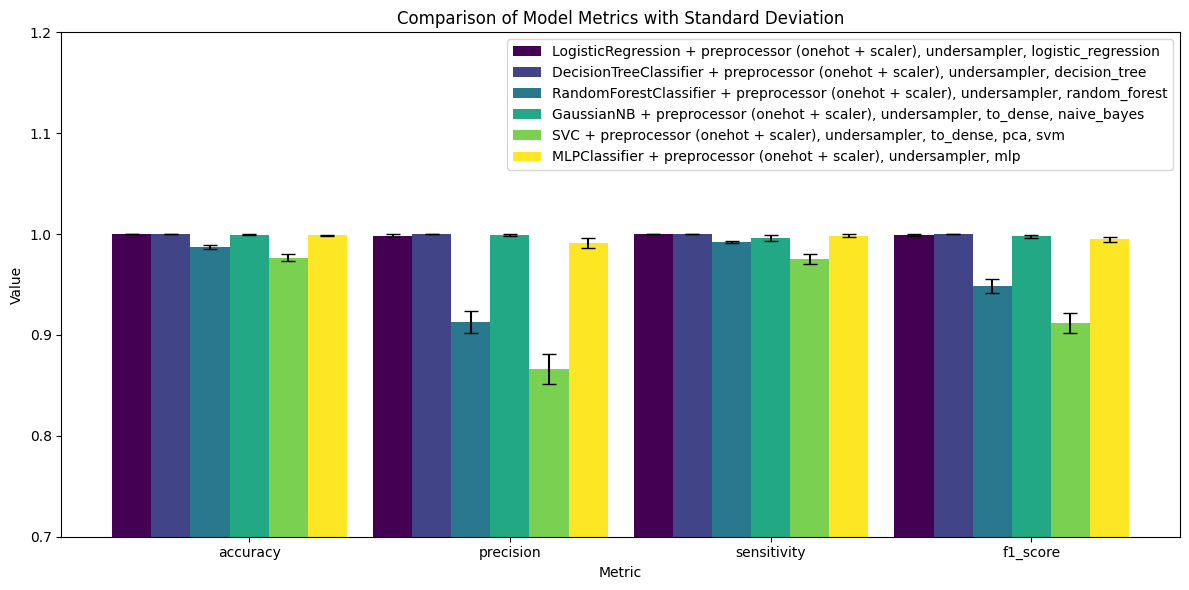

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, train_test_split

from cursos_df import seed_value, X, y
from pipelines import pipelines
from pretty_print import prettify, ascii_as_image, plot_model_metrics
from train_and_predict import train_and_predict

np.random.seed(seed_value)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed_value)

result = []

for pipeline in pipelines:
    result.append(
        train_and_predict(
            X_train=X_train,
            Y_train=y_train,
            X_test=X_test,
            y_test=y_test,
            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=seed_value),
            param_grid=pipeline['params'],
            pipeline=pipeline['pipeline'],
        )
    )

plot_model_metrics(result)
df = pd.DataFrame(result)

ascii_table = prettify(df, drop_columns=['best_estimator', 'all_results'])
ascii_as_image(ascii_table, 'classifiers.jpg')

cv_results = pd.DataFrame(df['all_results'])

# Get the number of splits (k in k-fold)
n_splits = sum(1 for key in cv_results if key.startswith("split") and key.endswith("test_score"))

# Get the number of parameter combinations
n_combinations = len(cv_results)